In [20]:
import pandas as pd
import numpy as np
import math
import random
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
pd.options.display.max_columns = 105

In [2]:
data = pd.read_csv('../input/mlbplaybyplay2010s/all2018.csv', low_memory=False)

# 타석 데이터만 남기기
pa_events = [2, 3, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
is_pa = data['EVENT_CD'].isin(pa_events)
print('타석 데이터의 비율: %.3f' % (sum(is_pa) / data.shape[0]))
data = data[is_pa].reset_index(drop=True)

타석 데이터의 비율: 0.969


# Transition matrix 구하기

In [3]:
# 주자 flag columns 추가
data['BASE1_RUN_FL'] = data['BASE1_RUN_ID'].notna()
data['BASE2_RUN_FL'] = data['BASE2_RUN_ID'].notna()
data['BASE3_RUN_FL'] = data['BASE3_RUN_ID'].notna()

# 초반, 후반 데이터 나누기
game_new_indices = data.index[data['GAME_NEW_FL'] == 'T']
train = data  # data.iloc[:game_new_indices[len(game_new_indices)//2]]
test = data.iloc[game_new_indices[len(game_new_indices)//2]:]

# state_action_cnt: 한 state에서 어떤 action을 하는 경우의 수
state_action_cnt = train.groupby(['OUTS_CT', 'BASE1_RUN_FL', 'BASE2_RUN_FL', 'BASE3_RUN_FL'])['EVENT_CD'].value_counts()

# result_cnt: 한 (state, action)에서 어떤 result로 가는 경우의 수
result_cnt = pd.pivot_table(train, values='EVENT_ID', index=['OUTS_CT', 'BASE1_RUN_FL', 'BASE2_RUN_FL', 'BASE3_RUN_FL', 'EVENT_CD'], columns=['EVENT_OUTS_CT', 'BAT_DEST_ID', 'RUN1_DEST_ID', 'RUN2_DEST_ID', 'RUN3_DEST_ID'], aggfunc='count').fillna(0.0).astype(int)

# trans_mat: 한 (state, action)에서 어떤 result로 갈 확률
trans_mat = result_cnt.apply(lambda x: x / state_action_cnt[result_cnt.index])

# 타자, 투수 policy 초기화

In [4]:
# 평균 타자 기록
bat = {}
bat['average'] = {'pa': train.shape[0]}
for event in pa_events:
    bat['average'][event] = 0
for index, row in train.iterrows():
    bat['average'][row['EVENT_CD']] += 1

# 초기화
for bat_id in train['BAT_ID'].unique():
    bat[bat_id] = {'pa': 0}
    for event in pa_events:
        bat[bat_id][event] = 0

# 각 타자의 event 개수 세기.
for index, row in train.iterrows():
    bat_id = row['BAT_ID']
    event = row['EVENT_CD']
    bat[bat_id]['pa'] += 1
    bat[bat_id][event] += 1

In [5]:
# 평균 투수 기록
pit = {}
pit['average'] = {'pa': train.shape[0]}
for event in pa_events:
    pit['average'][event] = 0
for index, row in train.iterrows():
    pit['average'][row['EVENT_CD']] += 1

# 초기화
for pit_id in train['PIT_ID'].unique():
    pit[pit_id] = {'pa': 0}
    for event in pa_events:
        pit[pit_id][event] = 0

# 각 투수의 event 개수 세기.
for index, row in train.iterrows():
    pit_id = row['PIT_ID']
    event = row['EVENT_CD']
    pit[pit_id]['pa'] += 1
    pit[pit_id][event] += 1

# 각 타석에서 각 event가 일어날 확률을 학습

In [6]:
# 초기화
event_dict = {}
for event in pa_events:
    event_dict['bat_'+str(event)] = []
    event_dict['pit_'+str(event)] = []
event_dict['result'] = []

# 각 타석에서 타자 policy와 투수 policy를 가져옴.
for index, row in train.iterrows():
    bat_id = row['BAT_ID']
    pit_id = row['PIT_ID']
    
    for event in pa_events:
        if bat[bat_id]['pa'] >= 100:
            event_dict['bat_'+str(event)].append(bat[bat_id][event] / bat[bat_id]['pa'])
        else:
            event_dict['bat_'+str(event)].append(bat['average'][event] / bat['average']['pa'])
        
        if pit[pit_id]['pa'] >= 100:
            event_dict['pit_'+str(event)].append(pit[pit_id][event] / pit[pit_id]['pa'])
        else:
            event_dict['pit_'+str(event)].append(pit['average'][event] / pit['average']['pa'])

    event_dict['result'].append(row['EVENT_CD'])
            
event_df = pd.DataFrame(event_dict)

In [7]:
X = event_df.drop('result', axis=1)
y = event_df['result']

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear')
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
# (action, proba)를 dictionary 형태로 받아서 random action을 선택하는 함수
def choose_rand_action(probas):
    probas = dict(probas)  # {2: 0.45, 3: 0.22, ...}
    choice = random.uniform(0, 1)
    accu = 0
    for action, proba in probas.items():
        accu += proba
        if choice < accu:
            return action
    return action

In [9]:
def get_policy(bat_id, pit_id):
    features = {}
    for event in pa_events:
        if bat_id in bat and bat[bat_id]['pa'] >= 100:
            features['bat_'+str(event)] = bat[bat_id][event] / bat[bat_id]['pa']
        else:
            features['bat_'+str(event)] = bat['average'][event] / bat['average']['pa']
        
        if pit_id in pit and pit[pit_id]['pa'] >= 100:
            features['pit_'+str(event)] = pit[pit_id][event] / pit[pit_id]['pa']
        else:
            features['pit_'+str(event)] = pit['average'][event] / pit['average']['pa']
            
    probas = model.predict_proba(np.fromiter(features.values(), dtype=float).reshape(1, -1))
    return {event: probas[0, index] for index, event in enumerate(pa_events)}

# Compute the inning's expected scores of given states

In [47]:
# 이닝 바뀌는 지점 구하기
train['INN_END_FL'] = train.apply(lambda row:
                                  row['OUTS_CT'] + row['EVENT_OUTS_CT'] == 3,
                                  axis=1)

In [42]:
# 각 타석에서의 득점 구하기
train['INN_RUNS_CT'] = train.apply(lambda row:
                                   (row['BAT_DEST_ID'] >= 4) + (row['RUN1_DEST_ID'] >= 4) + (row['RUN2_DEST_ID'] >= 4) + (row['RUN3_DEST_ID'] >= 4),
                                   axis=1)

In [49]:
# 한 줄씩 돌면서 아웃 카운트가 바뀌는 지점의 state들을 기억.
# 이닝이 끝나는 지점에서 기억해 둔 state들의 기대 점수를 갱신.
# state: ('OUTS_CT', 'BASE1_RUN_FL', 'BASE2_RUN_FL', 'BASE3_RUN_FL')
# expected_score: {state: (sum, cnt)}

expected_score = {}
states = []
inn_score = 0

for idx, row in train.iterrows():
    inn_score += row['INN_RUNS_CT']
    
    # 아웃 카운트가 바뀌는 지점.
    if row['EVENT_OUTS_CT'] != 0:
        states.append((row['OUTS_CT'], row['BASE1_RUN_FL'], row['BASE2_RUN_FL'], row['BASE3_RUN_FL']))
    
    # 이닝이 바뀌는 지점.
    if row['INN_END_FL']:
        for state in states:
            if state not in expected_score:
                expected_score[state] = [0, 0]
            expected_score[state][0] += inn_score
            expected_score[state][1] += 1
        states.clear()
        inn_score = 0

In [53]:
for state in expected_score:
    expected_score[state] = expected_score[state][0] / expected_score[state][1]

In [54]:
expected_score

{(0, False, False, False): 0.3444016682707732,
 (1, False, False, False): 0.2848728129499542,
 (2, False, False, False): 0.33342480790340284,
 (2, True, False, False): 0.44206008583690987,
 (1, True, False, False): 0.4576521204671174,
 (1, False, True, False): 0.7468944099378882,
 (2, False, True, False): 0.7193758733115976,
 (2, True, True, False): 0.6588360918312867,
 (0, True, False, False): 0.5807331111784307,
 (2, False, True, True): 0.8394222599830077,
 (1, True, True, False): 0.8462832156071308,
 (0, True, True, False): 1.1379507727532914,
 (1, True, True, True): 1.4905490549054905,
 (1, False, False, True): 1.1285574092247301,
 (0, False, True, False): 1.0421455938697317,
 (0, False, True, True): 1.9130434782608696,
 (1, False, True, True): 1.6100766703176341,
 (2, True, False, True): 0.8672782874617737,
 (2, False, False, True): 0.743124634289058,
 (2, True, True, True): 0.8723835246455098,
 (0, True, True, True): 2.208237986270023,
 (1, True, False, True): 1.3683781581092094,

# Simulation

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.42it/s]


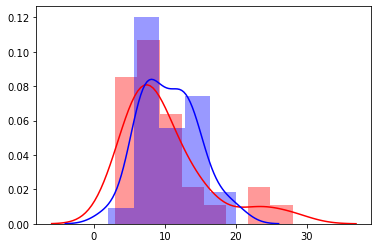

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

예상 점수 10.033333333333333 : 10.533333333333333
실제 점수 0 : 6


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.45it/s]


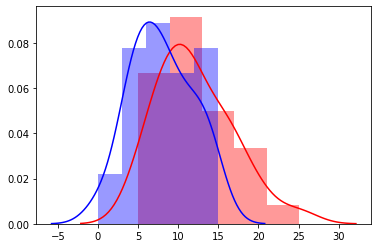

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

예상 점수 12.066666666666666 : 7.933333333333334
실제 점수 8 : 4


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:19<00:00,  1.52it/s]


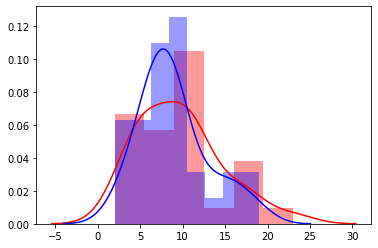

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

예상 점수 9.6 : 8.933333333333334
실제 점수 4 : 4


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.40it/s]


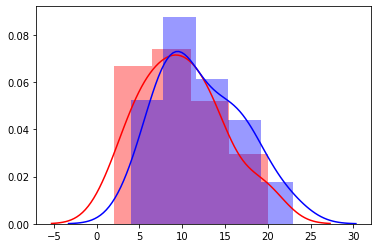

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

예상 점수 9.9 : 12.133333333333333
실제 점수 6 : 0


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


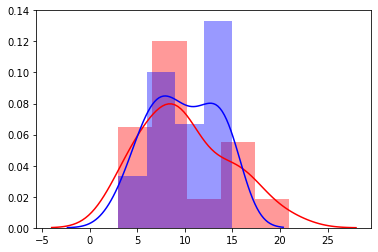

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

예상 점수 10.0 : 9.8
실제 점수 8 : 0


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.38it/s]


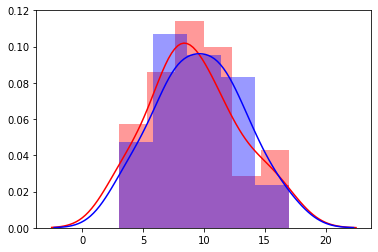

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

예상 점수 9.2 : 9.666666666666666
실제 점수 4 : 4


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.38it/s]


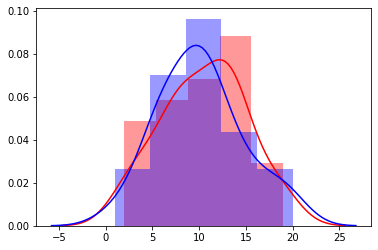

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

예상 점수 10.533333333333333 : 10.133333333333333
실제 점수 5 : 2


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.36it/s]


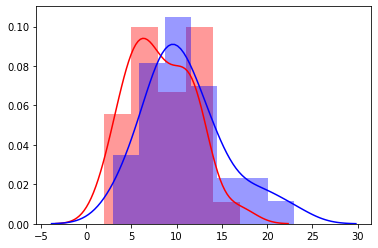

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

예상 점수 8.2 : 10.933333333333334
실제 점수 3 : 0


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:20<00:00,  1.46it/s]


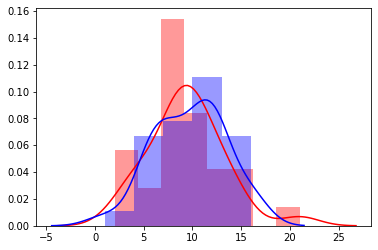

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

예상 점수 9.4 : 9.733333333333333
실제 점수 10 : 4


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.39it/s]


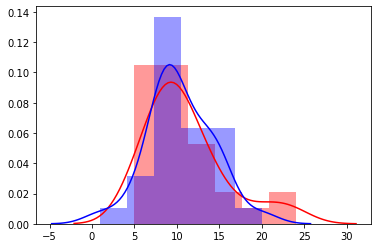

예상 점수 11.0 : 10.4
실제 점수 0 : 2


In [10]:
# 게임이 시작하는 indices.
start_indices = test.index[test['GAME_NEW_FL'] == 'T']

for i in range(10):  # range(len(start_indices)-1):
    this_game = test.loc[start_indices[i]:start_indices[i+1]-1]
    
    away_batters = list(this_game['BAT_ID'][this_game['BAT_HOME_ID'] == 0].head(9))
    home_batters = list(this_game['BAT_ID'][this_game['BAT_HOME_ID'] == 1].head(9))

    home_pitcher = this_game['PIT_ID'][this_game['BAT_HOME_ID'] == 0].iloc[0]
    away_pitcher = this_game['PIT_ID'][this_game['BAT_HOME_ID'] == 1].iloc[0]

    away_scores = []
    home_scores = []
    
    for case_num in tqdm(range(30)):
        state = {
            'INN_CT': 1,
            'BAT_HOME_ID': 0,
            'OUTS_CT': 0,
            'BASE1_RUN_FL': False,
            'BASE2_RUN_FL': False,
            'BASE3_RUN_FL': False,
            'AWAY_BAT_CD': 1,
            'HOME_BAT_CD': 1,
            'AWAY_SCORE_CT': 0,
            'HOME_SCORE_CT': 0,
            'END_FL': False
        }
        
        # Simulation
        while state['END_FL'] == False:
            if state['BAT_HOME_ID'] == 0:  # away team batting
                policy = get_policy(away_batters[state['AWAY_BAT_CD']-1], home_pitcher)
            else:  # home team batting
                policy = get_policy(home_batters[state['HOME_BAT_CD']-1], away_pitcher)

            action = choose_rand_action(policy)

            state_action = (state['OUTS_CT'], state['BASE1_RUN_FL'], state['BASE2_RUN_FL'], state['BASE3_RUN_FL'], action)
            if state_action in trans_mat.index:
                result = trans_mat.loc[state_action]

            EVENT_OUTS_CT, BAT_DEST_ID, RUN1_DEST_ID, RUN2_DEST_ID, RUN3_DEST_ID = choose_rand_action(result)

            state['OUTS_CT'] += EVENT_OUTS_CT

            base = [0, 0, 0, 0, 0, 0, 0]
            for runner in [BAT_DEST_ID, RUN1_DEST_ID, RUN2_DEST_ID, RUN3_DEST_ID]:
                base[runner] += 1

            # 득점 계산
            runs_scored = base[4] + base[5] + base[6]

            # 주자 갱신
            state['BASE1_RUN_FL'] = True if base[1] > 0 else False
            state['BASE2_RUN_FL'] = True if base[2] > 0 else False
            state['BASE3_RUN_FL'] = True if base[3] > 0 else False

            if state['BAT_HOME_ID'] == 0:  # away team 공격이면
                state['AWAY_BAT_CD'] = state['AWAY_BAT_CD'] % 9 + 1
                state['AWAY_SCORE_CT'] += runs_scored
            else:  # home team 공격
                state['HOME_BAT_CD'] = state['HOME_BAT_CD'] % 9 + 1
                state['HOME_SCORE_CT'] += runs_scored

            if state['OUTS_CT'] == 3:
                state['OUTS_CT'] = 0
                inning_end = True
            else:
                inning_end = False

            if inning_end:
                if state['BAT_HOME_ID'] == 1:
                    state['INN_CT'] += 1

                state['BAT_HOME_ID'] = 1 - state['BAT_HOME_ID']

                if state['INN_CT'] > 9 and state['AWAY_SCORE_CT'] != state['HOME_SCORE_CT']:
                    break

                if state['INN_CT'] > 12:
                    break
                    
        away_scores.append(state['AWAY_SCORE_CT'])
        home_scores.append(state['HOME_SCORE_CT'])
    
    sns.distplot(away_scores, color='r')
    sns.distplot(home_scores, color='b')
    plt.show()
    
    print('예상 결과:', away_scores)
    
    print(f'예상 점수 {np.mean(away_scores)} : {np.mean(home_scores)}')
    print(f"실제 점수 {this_game.iloc[-1]['AWAY_SCORE_CT']} : {this_game.iloc[-1]['HOME_SCORE_CT']}")